Obtain results of the samplers' performances, running times, etc.

In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from pprint import pprint
import pandas as pd
import pickle
from deepsig import aso

In [2]:
quantities = ['lp_ensemble', 'acc_ensemble', 'ece']
assert quantities[0] == 'lp_ensemble'

In [3]:
def get_best_lr(inference_temp, trials, lrs, inference_dir_temp, best_lrs, results_for_print, results_for_csv, verbose=False, ignore_fail=True, add_to_csv=True):
    if verbose:
        print(inference_temp)
    results_for_print[inference_temp] = dict()
    if add_to_csv:
        results_for_csv[inference_temp] = dict()
    available_lrs = []
    for quantity in quantities:
        if verbose:
            print(quantity)
        # results_for_print[inference_temp][quantity] = dict()
        if verbose:
            plt.figure()
        val_candidates = dict()
        val_temps = []
        test_candidates = dict()
        test_temps = []
        for lr in lrs:
            val_temp = []
            test_temp = []
            if not os.path.exists(f'../results/{inference_dir_temp(lr)}'):
                continue
            else:
                available_lrs.append(lr)
            for j in range(trials):
                if not os.path.exists(f'../results/{inference_dir_temp(lr)}/{j+1}'):
                    warnings_str = f"Missing run {j+1} for {inference_temp}, {lr}"
                    if "warnings" not in results_for_print[inference_temp]:
                        results_for_print[inference_temp]["warnings"] = [warnings_str]
                    else:
                        if warnings_str not in results_for_print[inference_temp]["warnings"]:
                            results_for_print[inference_temp]["warnings"].append(warnings_str)
                try:
                    name = f'../results/{inference_dir_temp(lr)}/{j+1}/run.json'
                    with open(name) as f:
                        run = json.load(f)
                    if run['status'] == "RUNNING":
                        warnings_str = f"Run {j+1} hasn't finished for {inference_temp}, {lr}"
                        if "warnings" not in results_for_print[inference_temp]:
                            results_for_print[inference_temp]["warnings"] = [warnings_str]
                        else:
                            if warnings_str not in results_for_print[inference_temp]["warnings"]:
                                results_for_print[inference_temp]["warnings"].append(warnings_str)
                    val_temp.append(run['result']['val'][quantity])
                    test_temp.append(run['result']['test'][quantity])
                except:
                    pass

            try:
                assert len(val_temp) == trials
                val_val = [np.mean(val_temp), np.std(val_temp), val_temp]
            except:
                val_val = [np.nan, np.nan, np.nan]
            val_temps.append(val_val)
            try:
                assert len(test_temp) == trials
                test_val = [np.mean(test_temp), np.std(test_temp), test_temp]
            except:
                test_val = [np.nan, np.nan, np.nan]
            test_temps.append(test_val)
            if len(val_temp) != trials:
                if not ignore_fail:
                    print(f"Warning: Some runs failed for {inference_temp}, {lr}")
            else:
                val_candidates[lr] = val_val
                test_candidates[lr] = test_val
        if verbose:
            plt.plot(val_candidates.keys(), [temp[0] for temp in val_candidates.values()], label=inference_temp+"_val")
            plt.plot(test_candidates.keys(), [temp[0] for temp in test_candidates.values()], label=inference_temp+"_test")
        
        if len(val_candidates) == 0:
            return best_lrs, results_for_print, results_for_csv
        else:
            if quantity == 'lp_ensemble':
                best_lr = max(val_candidates, key=lambda k: val_candidates.get(k)[0])
                best_lrs[inference_temp] = best_lr
            else:
                best_lr = best_lrs[inference_temp]
            if best_lr == available_lrs[0]:
                warnings_str = f"Warning: need more learning rates smaller than {lr} for {inference_temp}"
                if "warnings" not in results_for_print[inference_temp]:
                    results_for_print[inference_temp]["warnings"] = [warnings_str]
                else:
                    if warnings_str not in results_for_print[inference_temp]["warnings"]:
                        results_for_print[inference_temp]["warnings"].append(warnings_str)
            elif best_lr == available_lrs[-1]:
                warnings_str = f"Warning: need more learning rates larger than {lr} for {inference_temp}"
                if "warnings" not in results_for_print[inference_temp]:
                    results_for_print[inference_temp]["warnings"] = [warnings_str]
                else:
                    if warnings_str not in results_for_print[inference_temp]["warnings"]:
                        results_for_print[inference_temp]["warnings"].append(warnings_str)
            if verbose:
                print(best_lr, "val:", val_candidates[best_lr], "test:", test_candidates[best_lr])

            if verbose:
                plt.legend()
                plt.show()

            results_for_print[inference_temp]["best lr"] = best_lr
            if not inference_temp.startswith("MongeSGLD"):
                results_for_csv[inference_temp]["best lr"] = best_lr
            best_value = [round(temp, 4) for temp in test_candidates[best_lr][:2]]
            # best_value.append(test_candidates[best_lr][2])
            if quantity == "lp_ensemble":
                results_for_print[inference_temp]["val log probability"] = [round(temp, 4) for temp in val_candidates[best_lr][:2]]
                # results_for_print[inference_temp]["val log probability"].append(val_candidates[best_lr][2])
                results_for_print[inference_temp]["log probability"] = best_value
                if add_to_csv:
                    results_for_csv[inference_temp]["log probability"] = best_value
            elif quantity == "acc_ensemble":
                results_for_print[inference_temp]["accuracy"] = best_value
                if add_to_csv:
                    results_for_csv[inference_temp]["accuracy"] = best_value
            else:
                results_for_print[inference_temp][quantity] = best_value
                if add_to_csv:
                    results_for_csv[inference_temp][quantity] = best_value
            
    temp = []
    for j in range(trials):
        with open(f'../results/{inference_dir_temp(best_lrs[inference_temp])}/{j+1}/evaluations.pkl', 'rb') as f:
            _ = pickle.load(f)
            _ = pickle.load(f)
            curvatures = pickle.load(f)
        for curvature in curvatures:
            temp.append(curvature[0][0])
    curvature_mean = np.round(np.mean(temp), 4)
    curvature_std = np.round(np.std(temp), 4)
    results_for_print[inference_temp]["mean curvature"] = np.round(curvature_mean, 2)
    results_for_print[inference_temp]["range curvature"] = (np.round(np.max(temp), 4), np.round(np.min(temp), 4))
    if add_to_csv:
        results_for_csv[inference_temp]["mean curvature"] = np.round(curvature_mean, 2)
    return best_lrs, results_for_print, results_for_csv


In [4]:
def get_plots(data, inference, trials, lrs, other_args=None, verbose=False):
    best_lrs = dict()
    results_for_print = dict()
    results_for_csv = dict()
    if inference in other_args:
        for other_arg in other_args[inference]:
            inference_temp = inference+"_"+other_arg
            inference_dir_temp = lambda lr: f"{data}/{inference}_{lr}_{other_arg}"
            best_lrs, results_for_print, results_for_csv = get_best_lr(inference_temp, trials, lrs, inference_dir_temp, best_lrs, results_for_print, results_for_csv, verbose=verbose, add_to_csv=False)
        temps = dict()
        for other_arg in other_args[inference]:
            inference_temp = inference+"_"+other_arg
            if "val log probability" in results_for_print[inference_temp]:
                temps[other_arg] = results_for_print[inference_temp]["val log probability"]
        best_other_arg = max(temps, key=temps.get)
        results_for_print[inference] = results_for_print[inference+"_"+best_other_arg].copy()
        results_for_print[inference]["best other arg"] = best_other_arg
        results_for_csv[inference] = results_for_print[inference+"_"+best_other_arg].copy()
        del results_for_csv[inference]["range curvature"]
        del results_for_csv[inference]["val log probability"]
    else:
        inference_dir_temp = lambda lr: f"{data}/{inference}_{lr}"
        best_lrs, results_for_print, results_for_csv = get_best_lr(inference, trials, lrs, inference_dir_temp, best_lrs, results_for_print, results_for_csv, verbose=verbose, add_to_csv=True)
        
    return results_for_print, results_for_csv


In [5]:
def get_time_per_epoch(timestamps_dir):
    num_epochs_per_cycle = 20
    if "mnist" in timestamps_dir:
        num_steps_per_epoch = 500
    else:
        num_steps_per_epoch = 400

    diffs = []
    if "WenzelSGLD" in timestamps_dir:
        precond_diffs = []
    for i in range(3):
        temp_diffs = []
        if "WenzelSGLD" in timestamps_dir:
            temp_precond_diffs = []
        with open(f"{timestamps_dir}/{i+1}/evaluations.pkl", "rb") as f:
            _ = pickle.load(f)
            timestamps = pickle.load(f)
        if "WenzelSGLD" in timestamps_dir:
            num_timestamps_per_epoch = 2 * num_steps_per_epoch + 2
            assert len(timestamps) == 2 + num_epochs_per_cycle * num_timestamps_per_epoch
            for epoch in range(num_epochs_per_cycle):
                # 1st timestamp for start of cycle
                start_index = 1 + num_timestamps_per_epoch * epoch
                for step in range(num_steps_per_epoch):
                    temp_diffs.append(timestamps[start_index + 2 * step + 1] - timestamps[start_index + 2 * step])
                temp_precond_diffs.append(timestamps[start_index + 2 * step + 3] - timestamps[start_index + 2 * step + 2])
            assert (start_index + 2 * step + 1) == (len(timestamps) - 4)
            diffs.extend(temp_diffs[1000:])
            precond_diffs.extend(temp_precond_diffs)
        else:
            num_timestamps_per_epoch = 2 * num_steps_per_epoch
            assert len(timestamps) ==  2 + num_epochs_per_cycle * num_timestamps_per_epoch
            for epoch in range(num_epochs_per_cycle):
                # 1st timestamp for start of cycle
                start_index = 1 + num_timestamps_per_epoch * epoch
                for step in range(num_steps_per_epoch):
                    temp_diffs.append(timestamps[start_index + 2 * step + 1] - timestamps[start_index + 2 * step])
            assert (start_index + 2 * step + 1) == (len(timestamps) - 2)
            diffs.extend(temp_diffs[1000:])
            
    if "WenzelSGLD" in timestamps_dir:
        return np.round(np.mean(diffs) * num_steps_per_epoch + np.mean(precond_diffs), 1)
    else:
        return np.round(np.mean(diffs) * num_steps_per_epoch, 1)

In [6]:
def show_results(dataset, width_or_model, prior, other_args, lrs, sampling_decay='flat', trials=10, reverse=False, verbose=False, monge_as_identity=False):
    data = f"{dataset}_{width_or_model}_{prior}_1.0_100_flat_400_1000_evaluations"
    if not os.path.exists(f"../results/{data}"):
        print("No such dir")
        return
    final_results_for_print = dict()
    final_results_for_csv = dict()
    for (key, value) in lrs.items():
        results_for_print, results_for_csv = get_plots(data, key, trials, value, other_args=other_args, verbose=verbose)
        if key == "MongeSGLD":
            for (inference, result) in results_for_print.items():
                final_results_for_print[inference] = result
            for (inference, result) in results_for_csv.items():
                final_results_for_csv[inference] = result
            if not monge_as_identity:
                timestamps_dir = f"../results/{dataset}_{width_or_model}_{prior}_1.0_100_flat_20_1000/{key}_{results_for_print[key]['best lr']}_{results_for_print[key]['best other arg']}"
                time_per_epoch = get_time_per_epoch(timestamps_dir)
                final_results_for_print[key]["time per epoch"] = time_per_epoch
                final_results_for_csv[key]["time per epoch"] = time_per_epoch
        else:
            timestamps_dir = f"../results/{dataset}_{width_or_model}_{prior}_1.0_100_flat_20_1000/{key}_{results_for_print[key]['best lr']}"
            time_per_epoch = get_time_per_epoch(timestamps_dir)
            final_results_for_print[key] = results_for_print[key]
            final_results_for_csv[key] = results_for_csv[key]
            final_results_for_print[key]["time per epoch"] = time_per_epoch
            final_results_for_csv[key]["time per epoch"] = time_per_epoch
    if monge_as_identity:
        print("Monge reduced to identity")
        final_results_for_print["MongeSGLD"] = final_results_for_print["VanillaSGLD"].copy()
        final_results_for_csv["MongeSGLD"] = final_results_for_csv["VanillaSGLD"].copy()
        final_results_for_print["MongeSGLD"]["time per epoch"] = np.nan
        final_results_for_csv["MongeSGLD"]["time per epoch"] = np.nan
    # else:
    #     del final_results_for_csv["MongeSGLD"]["best lr"]
    pprint(final_results_for_print)
    df = pd.DataFrame(final_results_for_csv).transpose()
    if not os.path.exists("csvs"):
        os.mkdir("csvs")
    df = df.rename(columns={"log probability": "LP.", "accuracy": "Acc.", "mean curvature": "Curv.", "time per epoch": "T"})
    df = df.rename(index={"VanillaSGLD": "Identity", "WenzelSGLD": "Wenzel", "pSGLD": "RMSprop", "MongeSGLD": "Monge", "ShampooSGLD": "Shampoo"})
    df.to_csv(f"csvs/{data}.csv")
    return final_results_for_print


In [7]:
gaussian_lrs = dict()
gaussian_lrs["VanillaSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1]
gaussian_lrs["WenzelSGLD"] = [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]
gaussian_lrs["pSGLD"] = [0.000075, 0.0001, 0.00025, 0.0005, 0.00075]
gaussian_lrs["MongeSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
gaussian_lrs["ShampooSGLD"] = [0.00075, 0.001, 0.0025, 0.005, 0.0075]

In [8]:
horseshoe_lrs = dict()
horseshoe_lrs["VanillaSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
horseshoe_lrs["WenzelSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
horseshoe_lrs["pSGLD"] = [0.0001, 0.00025, 0.0005, 0.00075, 0.001]
horseshoe_lrs["MongeSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
horseshoe_lrs["ShampooSGLD"] = [0.001, 0.0025, 0.005, 0.0075, 0.01]

# MNIST classificationdensenet 400 gaussian

In [9]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.5", "monge_alpha_2=0.1"]

results = show_results("mnist", "400", "gaussian", other_args, gaussian_lrs, monge_as_identity=True)


Monge reduced to identity
{'MongeSGLD': {'accuracy': [0.9685, 0.0005],
               'best lr': 0.05,
               'ece': [0.043, 0.0004],
               'log probability': [-0.131, 0.0004],
               'mean curvature': 5.93,
               'range curvature': (6.3099, 4.2598),
               'time per epoch': nan,
               'val log probability': [-0.1394, 0.0003]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.9687, 0.0004],
                                 'best lr': 0.05,
                                 'ece': [0.0433, 0.0004],
                                 'log probability': [-0.1308, 0.0004],
                                 'mean curvature': 5.97,
                                 'range curvature': (6.3659, 4.3253),
                                 'val log probability': [-0.1393, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.5': {'accuracy': [0.9684, 0.0005],
                                 'best lr': 0.05,
                                 'ece': [0.0436, 0.0004],
   

# MNIST classificationdensenet 400 horseshoe

In [10]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=3.0", "monge_alpha_2=2.75", "monge_alpha_2=2.5", "monge_alpha_2=2.25", "monge_alpha_2=2.0", "monge_alpha_2=1.75", "monge_alpha_2=1.5", "monge_alpha_2=1.25", "monge_alpha_2=1.0", "monge_alpha_2=0.75", "monge_alpha_2=0.5", "monge_alpha_2=0.25", "monge_alpha_2=0.1", "monge_alpha_2=0.05"]

lrs = dict()
lrs["VanillaSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
lrs["WenzelSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
lrs["pSGLD"] = [0.0001, 0.00025, 0.0005, 0.00075, 0.001]
lrs["MongeSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
lrs["ShampooSGLD"] = [0.001, 0.0025, 0.005, 0.0075, 0.01]
results = show_results("mnist", "400", "horseshoe", other_args, lrs)


{'MongeSGLD': {'accuracy': [0.9831, 0.0005],
               'best lr': 0.25,
               'best other arg': 'monge_alpha_2=1.25',
               'ece': [0.018, 0.0009],
               'log probability': [-0.0629, 0.0009],
               'mean curvature': 15.08,
               'range curvature': (22.079, 6.2514),
               'time per epoch': 12.9,
               'val log probability': [-0.0691, 0.0008]},
 'MongeSGLD_monge_alpha_2=0.05': {'accuracy': [0.9827, 0.0003],
                                  'best lr': 0.25,
                                  'ece': [0.0269, 0.0003],
                                  'log probability': [-0.0726, 0.0004],
                                  'mean curvature': 15.52,
                                  'range curvature': (19.7596, 5.1697),
                                  'val log probability': [-0.0792, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.9829, 0.0004],
                                 'best lr': 0.25,
                    

In [11]:
number = 1.96

# starting from alpha^{2}=2.5, it no longer works
alpha_2s = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
lp_ensembles = np.array([results[f'MongeSGLD_monge_alpha_2={alpha_2}']['log probability'][0] for alpha_2 in alpha_2s])
lp_ensembles_ci = np.array([number * results[f'MongeSGLD_monge_alpha_2={alpha_2}']['log probability'][1] for alpha_2 in alpha_2s])
acc_ensembles = np.array([results[f'MongeSGLD_monge_alpha_2={alpha_2}']['accuracy'][0] for alpha_2 in alpha_2s])
acc_ensembles_ci = np.array([number * results[f'MongeSGLD_monge_alpha_2={alpha_2}']['accuracy'][1] for alpha_2 in alpha_2s])


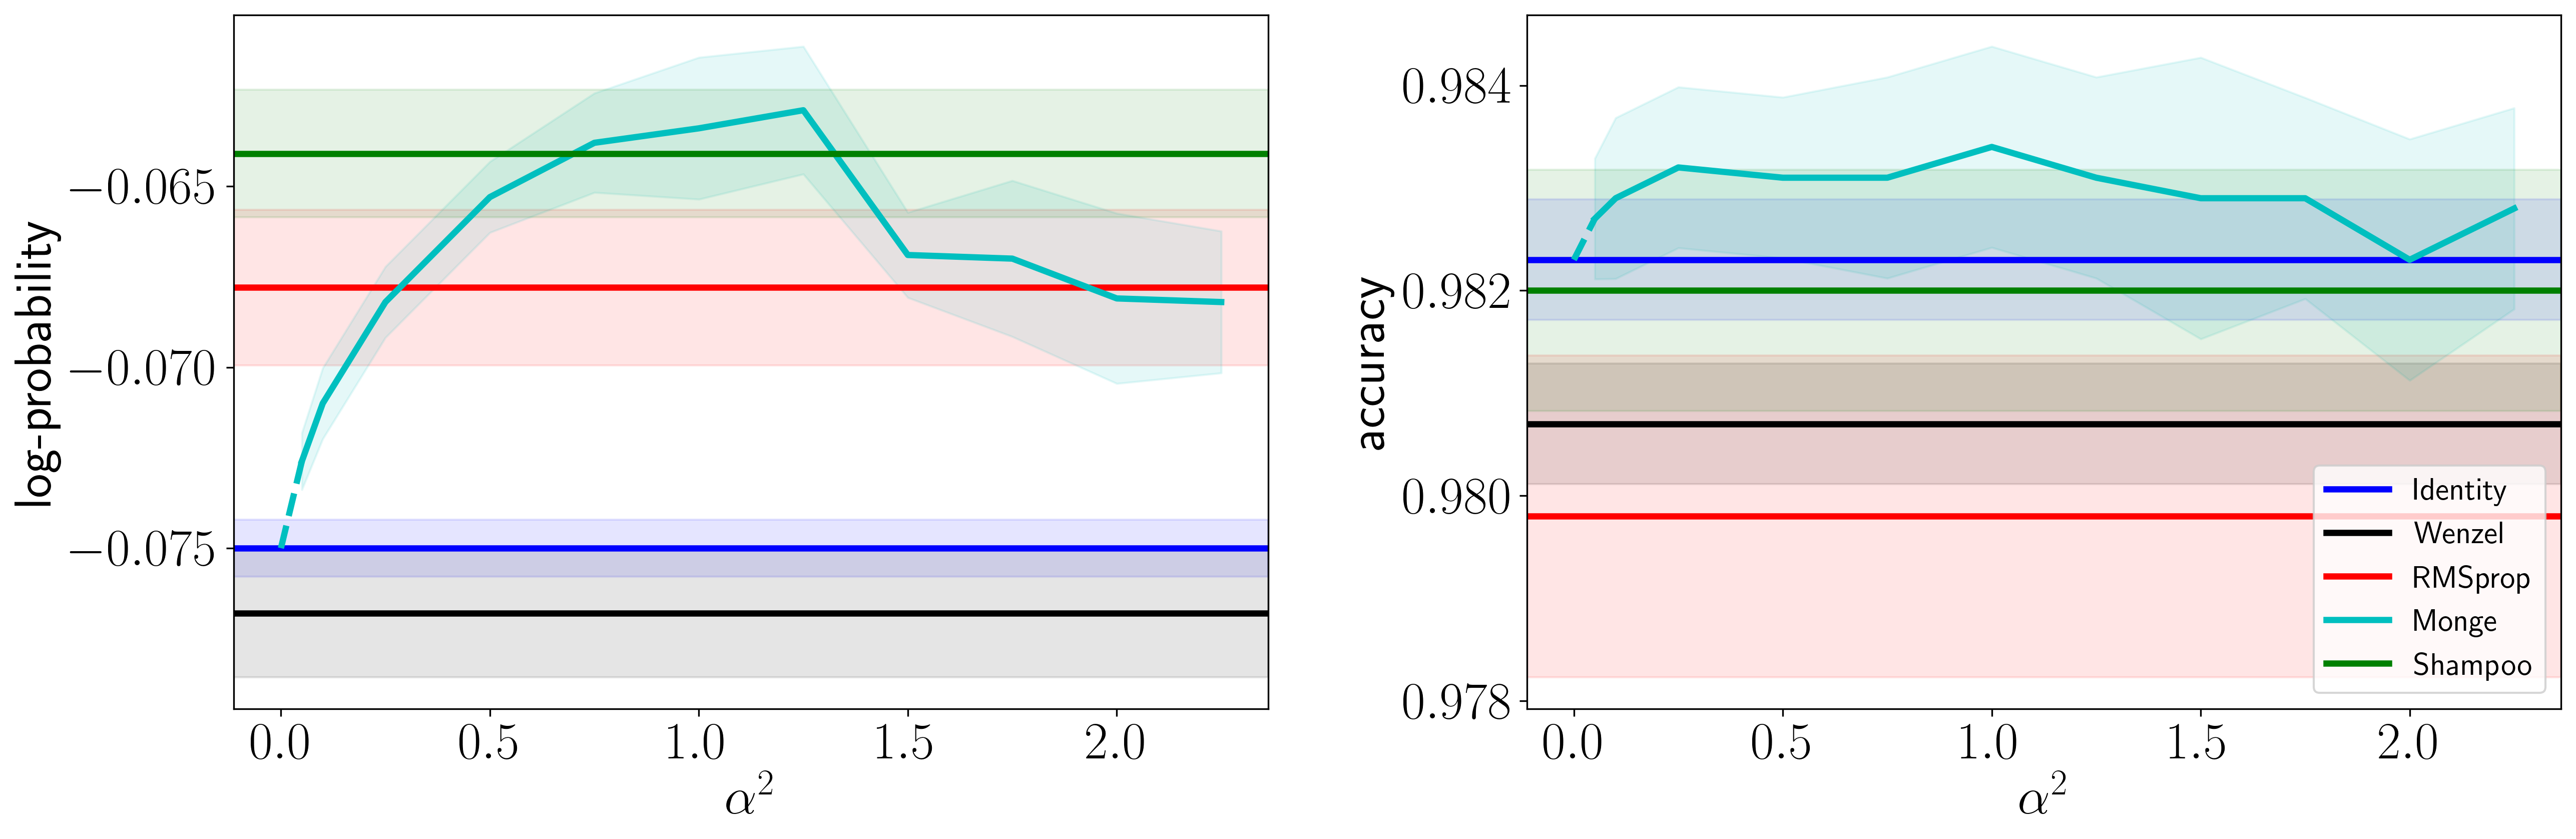

In [12]:
horizontal = True

if horizontal:
    plt.figure(figsize=(20, 6), dpi=300)
else:
    plt.figure(figsize=(10, 10), dpi=300)
plt.rcParams["font.size"] = 25
plt.rcParams["text.usetex"] = True

if horizontal:
    ax1 = plt.subplot(121)
else:
    ax1 = plt.subplot(211)

center = results['VanillaSGLD']['log probability'][0]
ci = number * results['VanillaSGLD']['log probability'][1]
ax1.axhline(center, label='Identity', color='b', linewidth=3.0)
ax1.axhspan(center-ci, center+ci, color='b', alpha=0.1)

center = results['WenzelSGLD']['log probability'][0]
ci = number * results['WenzelSGLD']['log probability'][1]
ax1.axhline(center, label='Wenzel', color='k', linewidth=3.0)
ax1.axhspan(center-ci, center+ci, color='k', alpha=0.1)

center = results['pSGLD']['log probability'][0]
ci = number * results['pSGLD']['log probability'][1]
ax1.axhline(center, label='RMSprop', color='r', linewidth=3.0)
ax1.axhspan(center-ci, center+ci, color='r', alpha=0.1)

ax1.plot(alpha_2s, lp_ensembles, label='Monge', color='c', linewidth=3.0)
ax1.fill_between(alpha_2s, lp_ensembles-lp_ensembles_ci, lp_ensembles+lp_ensembles_ci, color='c', alpha=0.1)
ax1.plot([0.0, alpha_2s[0]], [results['VanillaSGLD']['log probability'][0], lp_ensembles[0]], '--', color='c', linewidth=3.0)

center = results['ShampooSGLD']['log probability'][0]
ci = number * results['ShampooSGLD']['log probability'][1]
ax1.axhline(center, label='Shampoo', color='g', linewidth=3.0)
ax1.axhspan(center-ci, center+ci, color='g', alpha=0.1)

ax1.set_xlabel(r'$\alpha^{2}$')
ax1.set_ylabel("log-probability")

if horizontal:
    ax2 = plt.subplot(122)
    plt.subplots_adjust(wspace=0.25)
else:
    ax2 = plt.subplot(212)
    plt.subplots_adjust(hspace=0.3)

center = results['VanillaSGLD']['accuracy'][0]
ci = number * results['VanillaSGLD']['accuracy'][1]
ax2.axhline(center, label='Identity', color='b', linewidth=3.0)
ax2.axhspan(center-ci, center+ci, color='b', alpha=0.1)

center = results['WenzelSGLD']['accuracy'][0]
ci = number * results['WenzelSGLD']['accuracy'][1]
ax2.axhline(center, label='Wenzel', color='k', linewidth=3.0)
ax2.axhspan(center-ci, center+ci, color='k', alpha=0.1)

center = results['pSGLD']['accuracy'][0]
ci = number * results['pSGLD']['accuracy'][1]
ax2.axhline(center, label='RMSprop', color='r', linewidth=3.0)
ax2.axhspan(center-ci, center+ci, color='r', alpha=0.1)

ax2.plot(alpha_2s, acc_ensembles, label='Monge', color='c', linewidth=3.0)
ax2.fill_between(alpha_2s, acc_ensembles-acc_ensembles_ci, acc_ensembles+acc_ensembles_ci, color='c', alpha=0.1)
ax2.plot([0.0, alpha_2s[0]], [results['VanillaSGLD']['accuracy'][0], acc_ensembles[0]], '--', color='c', linewidth=3.0)

center = results['ShampooSGLD']['accuracy'][0]
ci = number * results['ShampooSGLD']['accuracy'][1]
ax2.axhline(center, label='Shampoo', color='g', linewidth=3.0)
ax2.axhspan(center-ci, center+ci, color='g', alpha=0.1)

ax2.set_xlabel(r'$\alpha^2$')
ax2.set_ylabel("accuracy")
plt.legend(loc="lower right", prop={"size": 15})
if horizontal:
    plt.savefig('figs/sensitivity_2_h.png', bbox_inches="tight")
else:
    plt.savefig('figs/sensitivity_2.png', bbox_inches="tight")


# MNIST classificationdensenet 800 gaussian

In [13]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.5", "monge_alpha_2=0.1"]

lrs = dict()
lrs["VanillaSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1]
lrs["WenzelSGLD"] = [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]
lrs["pSGLD"] = [0.000075, 0.0001, 0.00025, 0.0005, 0.00075]
lrs["MongeSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
lrs["ShampooSGLD"] = [0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]

_ = show_results("mnist", "800", "gaussian", other_args, lrs, monge_as_identity=True)


Monge reduced to identity
{'MongeSGLD': {'accuracy': [0.9587, 0.0003],
               'best lr': 0.05,
               'ece': [0.0525, 0.0003],
               'log probability': [-0.1667, 0.0004],
               'mean curvature': 4.69,
               'range curvature': (4.9567, 3.9245),
               'time per epoch': nan,
               'val log probability': [-0.1748, 0.0003]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.9586, 0.0005],
                                 'best lr': 0.05,
                                 'ece': [0.0525, 0.0005],
                                 'log probability': [-0.1668, 0.0003],
                                 'mean curvature': 4.76,
                                 'range curvature': (5.0171, 3.9277),
                                 'val log probability': [-0.175, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.5': {'accuracy': [0.9584, 0.0003],
                                 'best lr': 0.05,
                                 'ece': [0.0527, 0.0004],
  

# MNIST classificationdensenet 800 horseshoe

In [14]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.75", "monge_alpha_2=0.5", "monge_alpha_2=0.25", "monge_alpha_2=0.1"]

_ = show_results("mnist", "800", "horseshoe", other_args, horseshoe_lrs)


{'MongeSGLD': {'accuracy': [0.9834, 0.0008],
               'best lr': 0.25,
               'best other arg': 'monge_alpha_2=0.5',
               'ece': [0.0178, 0.0009],
               'log probability': [-0.0612, 0.0014],
               'mean curvature': 12.09,
               'range curvature': (22.1135, 3.3277),
               'time per epoch': 32.1,
               'val log probability': [-0.0671, 0.0012]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.983, 0.0003],
                                 'best lr': 0.25,
                                 'ece': [0.0269, 0.0003],
                                 'log probability': [-0.072, 0.0005],
                                 'mean curvature': 17.04,
                                 'range curvature': (21.8795, 5.6948),
                                 'val log probability': [-0.0784, 0.0003]},
 'MongeSGLD_monge_alpha_2=0.25': {'accuracy': [0.9834, 0.0003],
                                  'best lr': 0.25,
                          

# MNIST classificationdensenet 1200 gaussian

In [15]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.75", "monge_alpha_2=0.5", "monge_alpha_2=0.25", "monge_alpha_2=0.1"]

lrs = dict()
lrs["VanillaSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1]
lrs["WenzelSGLD"] = [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]
lrs["pSGLD"] = [0.000075, 0.0001, 0.00025, 0.0005, 0.00075]
# lrs["MongeSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
lrs["MongeSGLD"] = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
lrs["ShampooSGLD"] = [0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025]
_ = show_results("mnist", "1200", "gaussian", other_args, lrs)


{'MongeSGLD': {'accuracy': [0.956, 0.0005],
               'best lr': 0.025,
               'best other arg': 'monge_alpha_2=0.75',
               'ece': [0.0546, 0.0004],
               'log probability': [-0.178, 0.0005],
               'mean curvature': 6.92,
               'range curvature': (7.5704, 3.5336),
               'time per epoch': 59.2,
               'val log probability': [-0.1854, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.9518, 0.0004],
                                 'best lr': 0.025,
                                 'ece': [0.057, 0.0005],
                                 'log probability': [-0.1927, 0.0003],
                                 'mean curvature': 4.31,
                                 'range curvature': (4.5204, 3.4087),
                                 'val log probability': [-0.2005, 0.0002]},
 'MongeSGLD_monge_alpha_2=0.25': {'accuracy': [0.952, 0.0004],
                                  'best lr': 0.025,
                            

# MNIST classificationdensenet 1200 horseshoe

In [16]:
other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=0.1", "monge_alpha_2=0.075", "monge_alpha_2=0.05"]

lrs = dict()
lrs["VanillaSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
lrs["WenzelSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
lrs["pSGLD"] = [0.0001, 0.00025, 0.0005, 0.00075, 0.001]
lrs["MongeSGLD"] = [0.075, 0.1, 0.25, 0.5]
lrs["ShampooSGLD"] = [0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]
_ = show_results("mnist", "1200", "horseshoe", other_args, lrs)


{'MongeSGLD': {'accuracy': [0.9833, 0.0004],
               'best lr': 0.25,
               'best other arg': 'monge_alpha_2=0.075',
               'ece': [0.0252, 0.0005],
               'log probability': [-0.0694, 0.0005],
               'mean curvature': 16.78,
               'range curvature': (22.9238, 8.7479),
               'time per epoch': 60.1,
               'val log probability': [-0.0756, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.05': {'accuracy': [0.9832, 0.0003],
                                  'best lr': 0.25,
                                  'ece': [0.027, 0.0003],
                                  'log probability': [-0.0717, 0.0004],
                                  'mean curvature': 17.16,
                                  'range curvature': (22.377, 7.9805),
                                  'val log probability': [-0.078, 0.0004]},
 'MongeSGLD_monge_alpha_2=0.075': {'accuracy': [0.9833, 0.0004],
                                   'best lr': 0.25,
                

# CIFAR10 googleresnet gaussian

In [17]:
resnet_lrs = dict()
resnet_lrs["VanillaSGLD"] = [0.05, 0.075, 0.1, 0.25, 0.5]
resnet_lrs["WenzelSGLD"] = [0.1, 0.25, 0.5, 0.75, 1.0]
resnet_lrs["pSGLD"] = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
resnet_lrs["MongeSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
resnet_lrs["ShampooSGLD"] = [0.005, 0.0075, 0.01, 0.025, 0.05]

other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.5", "monge_alpha_2=0.1"]

_ = show_results("cifar10", "googleresnet", "gaussian", other_args, resnet_lrs, monge_as_identity=True)


Monge reduced to identity
{'MongeSGLD': {'accuracy': [0.8591, 0.0015],
               'best lr': 0.1,
               'ece': [0.0919, 0.0032],
               'log probability': [-0.4627, 0.0039],
               'mean curvature': 10.18,
               'range curvature': (14.1572, 1.6711),
               'time per epoch': nan,
               'val log probability': [-0.4525, 0.0036]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.8571, 0.0016],
                                 'best lr': 0.1,
                                 'ece': [0.0933, 0.0016],
                                 'log probability': [-0.4686, 0.0036],
                                 'mean curvature': 10.05,
                                 'range curvature': (13.7892, 1.6869),
                                 'val log probability': [-0.4575, 0.0041]},
 'MongeSGLD_monge_alpha_2=0.5': {'accuracy': [0.8537, 0.0026],
                                 'best lr': 0.1,
                                 'ece': [0.0963, 0.0025],


# CIFAR10 correlatedgoogleresnet convcorrnormal

In [18]:
corr_lrs = dict()
corr_lrs["VanillaSGLD"] = [0.05, 0.075, 0.1, 0.25, 0.5]
corr_lrs["WenzelSGLD"] = [0.25, 0.5, 0.75, 1.0, 1.25]
corr_lrs["pSGLD"] = [0.00025, 0.0005, 0.00075, 0.001, 0.0025]
corr_lrs["MongeSGLD"] = [0.075, 0.1, 0.25, 0.5, 0.75]
corr_lrs["ShampooSGLD"] = [0.0075, 0.01, 0.025, 0.05, 0.075]

other_args = dict()
other_args["MongeSGLD"] = ["monge_alpha_2=1.0", "monge_alpha_2=0.5", "monge_alpha_2=0.1"]

_ = show_results("cifar10", "correlatedgoogleresnet", "convcorrnormal", other_args, corr_lrs, monge_as_identity=True)


Monge reduced to identity
{'MongeSGLD': {'accuracy': [0.8641, 0.0025],
               'best lr': 0.1,
               'ece': [0.0861, 0.002],
               'log probability': [-0.4437, 0.004],
               'mean curvature': 9.91,
               'range curvature': (13.3801, 1.5063),
               'time per epoch': nan,
               'val log probability': [-0.4326, 0.0039]},
 'MongeSGLD_monge_alpha_2=0.1': {'accuracy': [0.8628, 0.0027],
                                 'best lr': 0.1,
                                 'ece': [0.0857, 0.0024],
                                 'log probability': [-0.4476, 0.0029],
                                 'mean curvature': 9.73,
                                 'range curvature': (13.3288, 1.6309),
                                 'val log probability': [-0.436, 0.0031]},
 'MongeSGLD_monge_alpha_2=0.5': {'accuracy': [0.8592, 0.0017],
                                 'best lr': 0.1,
                                 'ece': [0.0882, 0.0018],
     

# the end